# Session 8: Transformer Models and Attention Mechanisms

## 📚 Learning Objectives
By the end of this session, you will be able to:
- Understand the architecture and components of Transformer models
- Explain attention mechanisms and their role in NLP
- Implement basic attention mechanisms from scratch
- Use pre-trained Transformer models for various NLP tasks
- Compare different Transformer architectures (BERT, GPT, T5)
- Fine-tune Transformer models for specific applications

## 🎯 Session Overview
1. **Introduction to Transformers** - Architecture and key innovations
2. **Attention Mechanisms** - Self-attention and multi-head attention
3. **Pre-trained Models** - BERT, GPT, T5, and others
4. **Practical Implementation** - Using transformers library
5. **Fine-tuning Techniques** - Task-specific adaptation
6. **Performance Evaluation** - Benchmarking and optimization

---

In [6]:
# Required imports for Transformer models and attention
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# Transformers library
try:
    from transformers import (
        AutoTokenizer, AutoModel, AutoModelForSequenceClassification,
        BertTokenizer, BertModel, GPT2Tokenizer, GPT2Model,
        T5Tokenizer, T5Model, pipeline
    )
    transformers_available = True
    print("✅ Transformers library loaded successfully")
except ImportError:
    transformers_available = False
    print("❌ Transformers library not available. Install with: pip install transformers")

# Other useful libraries
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("📦 All imports completed!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ Transformers library loaded successfully
📦 All imports completed!
PyTorch version: 2.6.0+cu124
CUDA available: False


## Section 1: Understanding Transformer Architecture

### 1.1 The Transformer Revolution

**Key Innovations:**
- **Self-Attention**: Allows the model to focus on different parts of the input
- **Parallel Processing**: Unlike RNNs, Transformers can process all positions simultaneously
- **Position Encoding**: Captures sequence order without recurrence
- **Multi-Head Attention**: Multiple attention patterns in parallel

### 1.2 Core Components
1. **Encoder-Decoder Architecture** (Original Transformer)
2. **Encoder-Only Models** (BERT-style)
3. **Decoder-Only Models** (GPT-style)
4. **Encoder-Decoder Models** (T5-style)

🔍 ATTENTION MECHANISMS DEMONSTRATION
Sample input shape: torch.Size([2, 5, 8])
\n📊 Simple Attention Results:
Context vector shape: torch.Size([2, 8])
Attention weights shape: torch.Size([2, 5])
Attention weights (first sequence): [0.33781162 0.11843887 0.08237679 0.08302546 0.37834734]
\n🧠 Multi-Head Attention Results:
Output shape: torch.Size([2, 5, 8])
Attention weights shape: torch.Size([2, 4, 5, 5])


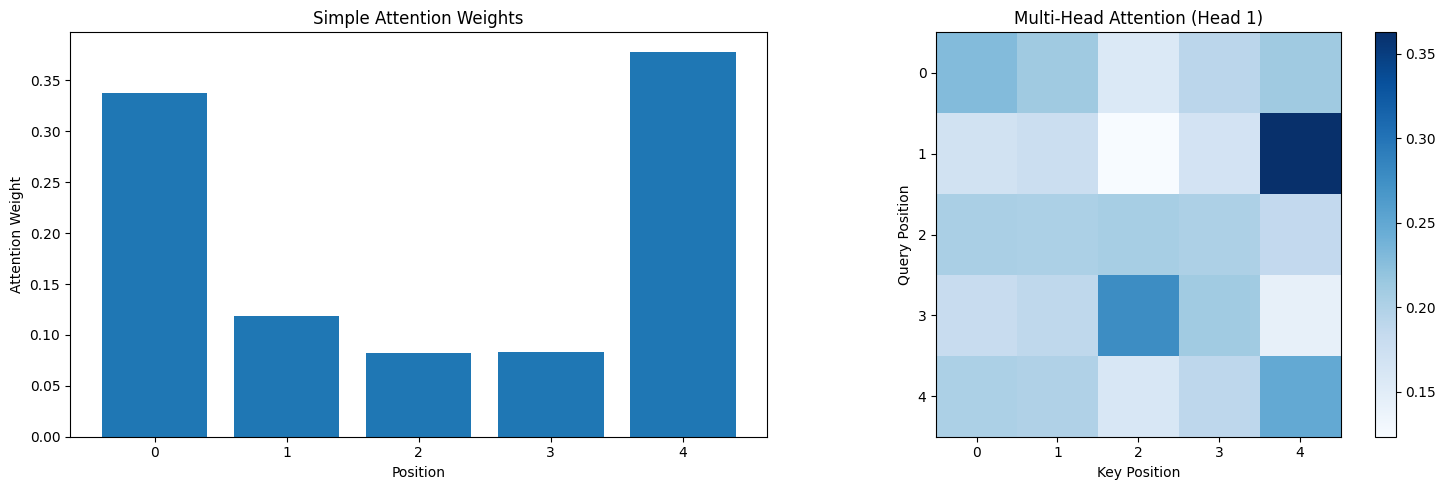

In [7]:
# Simple Attention Mechanism Implementation

class SimpleAttention(nn.Module):
    """Simple attention mechanism implementation"""

    def __init__(self, hidden_dim):
        super(SimpleAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, encoder_outputs):
        # encoder_outputs shape: (batch_size, seq_len, hidden_dim)

        # Calculate attention weights
        attention_weights = self.attention(encoder_outputs)  # (batch_size, seq_len, 1)
        attention_weights = F.softmax(attention_weights.squeeze(-1), dim=1)  # (batch_size, seq_len)

        # Apply attention weights
        context_vector = torch.sum(encoder_outputs * attention_weights.unsqueeze(-1), dim=1)

        return context_vector, attention_weights

class MultiHeadAttention(nn.Module):
    """Multi-head attention mechanism"""

    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(scores, dim=-1)
        context = torch.matmul(attention_weights, V)
        return context, attention_weights

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Linear transformations and split into heads
        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Apply attention
        context, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)

        # Concatenate heads
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        # Final linear transformation
        output = self.W_o(context)

        return output, attention_weights

# Demonstrate attention mechanisms
print("🔍 ATTENTION MECHANISMS DEMONSTRATION")
print("=" * 60)

# Create sample data
batch_size = 2
seq_length = 5
hidden_dim = 8

# Sample input embeddings
sample_embeddings = torch.randn(batch_size, seq_length, hidden_dim)
print(f"Sample input shape: {sample_embeddings.shape}")

# Simple Attention
simple_attention = SimpleAttention(hidden_dim)
context_vector, attention_weights = simple_attention(sample_embeddings)

print(f"\\n📊 Simple Attention Results:")
print(f"Context vector shape: {context_vector.shape}")
print(f"Attention weights shape: {attention_weights.shape}")
print(f"Attention weights (first sequence): {attention_weights[0].detach().numpy()}")

# Multi-Head Attention
num_heads = 4
multi_head_attention = MultiHeadAttention(hidden_dim, num_heads)
output, mh_attention_weights = multi_head_attention(sample_embeddings, sample_embeddings, sample_embeddings)

print(f"\\n🧠 Multi-Head Attention Results:")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {mh_attention_weights.shape}")

# Visualize attention patterns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Simple attention visualization
axes[0].bar(range(seq_length), attention_weights[0].detach().numpy())
axes[0].set_title('Simple Attention Weights')
axes[0].set_xlabel('Position')
axes[0].set_ylabel('Attention Weight')

# Multi-head attention visualization (first head)
im = axes[1].imshow(mh_attention_weights[0, 0].detach().numpy(), cmap='Blues')
axes[1].set_title('Multi-Head Attention (Head 1)')
axes[1].set_xlabel('Key Position')
axes[1].set_ylabel('Query Position')
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

## Section 2: Pre-trained Transformer Models

### 2.1 Model Categories
- **BERT (Bidirectional Encoder Representations from Transformers)**
  - Encoder-only architecture
  - Bidirectional context understanding
  - Best for: Classification, NER, QA

- **GPT (Generative Pre-trained Transformer)**
  - Decoder-only architecture
  - Autoregressive generation
  - Best for: Text generation, completion

- **T5 (Text-to-Text Transfer Transformer)**
  - Encoder-decoder architecture
  - Unified text-to-text framework
  - Best for: Translation, summarization, QA

### 2.2 Model Sizes and Variants
- **Base models**: ~110M parameters
- **Large models**: ~340M parameters
- **XL/XXL models**: 1B+ parameters

🚀 TRANSFORMER MODELS IN ACTION
\n1️⃣ BERT Model Demonstration:


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


✅ Loaded BERT model: bert-base-uncased
\n📊 BERT Analysis Results:
Embedding dimension: 768
\nText 1: The weather is beautiful today.
Tokens: ['the', 'weather', 'is', 'beautiful', 'today', '.']
Embedding norm: 15.0897
\nText 2: I love machine learning and artificial intelligence.
Tokens: ['i', 'love', 'machine', 'learning', 'and', 'artificial', 'intelligence', '.']
Embedding norm: 15.0328
\nText 3: The stock market had a volatile day with significant price movements.
Tokens: ['the', 'stock', 'market', 'had', 'a', 'volatile', 'day', 'with', 'significant', 'price', 'movements', '.']
Embedding norm: 14.5567


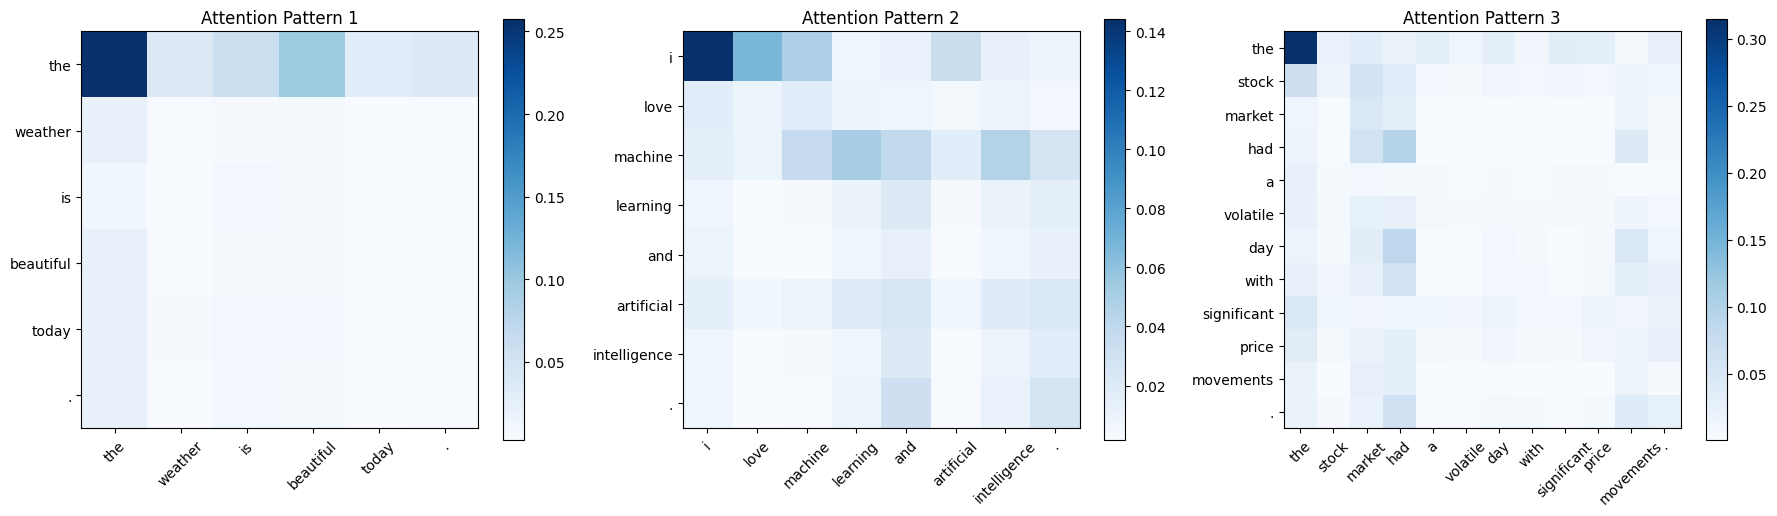

\n2️⃣ GPT-2 Model Demonstration:


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


✅ Loaded GPT-2 model: gpt2
\n🤖 GPT-2 Text Generation:
\nPrompt: 'Artificial intelligence will revolutionize'
------------------------------
Generation 1: Artificial intelligence will revolutionizethe world, but you need to be prepared for everything. We need to learn from each other, and the greater good must be done for each other.

You are the only one who knows what your future holds
\nPrompt: 'The future of natural language processing'
------------------------------
Generation 1: The future of natural language processingis also in the hands of AI, as Google knows that it will be able to recognize and understand a variety of language in the future.

The ability to program speech to human speech is a big deal. But
\nPrompt: 'Machine learning algorithms can help'
------------------------------
Generation 1: Machine learning algorithms can helpus understand what we want to predict and what we want to know about what we want to predict about our knowledge. They will also help us explore

In [5]:
# Working with Pre-trained Transformer Models

def demonstrate_bert_usage():
    """Demonstrate BERT model usage for various tasks"""
    if not transformers_available:
        print("❌ Transformers library not available")
        return

    try:
        # Load BERT model and tokenizer
        model_name = "bert-base-uncased"
        tokenizer = BertTokenizer.from_pretrained(model_name)
        model = BertModel.from_pretrained(model_name)

        print(f"✅ Loaded BERT model: {model_name}")

        # Sample texts for analysis
        texts = [
            "The weather is beautiful today.",
            "I love machine learning and artificial intelligence.",
            "The stock market had a volatile day with significant price movements."
        ]

        # Process texts and get embeddings
        embeddings = []
        attention_weights = []

        for text in texts:
            # Tokenize
            inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

            # Get model outputs
            with torch.no_grad():
                outputs = model(**inputs, output_attentions=True)

                # Extract embeddings (use [CLS] token)
                cls_embedding = outputs.last_hidden_state[0, 0, :].numpy()
                embeddings.append(cls_embedding)

                # Extract attention weights from last layer, first head
                attention = outputs.attentions[-1][0, 0, :, :].numpy()
                attention_weights.append(attention)

        # Display results
        print(f"\\n📊 BERT Analysis Results:")
        print(f"Embedding dimension: {len(embeddings[0])}")

        for i, text in enumerate(texts):
            tokens = tokenizer.tokenize(text)
            print(f"\\nText {i+1}: {text}")
            print(f"Tokens: {tokens}")
            print(f"Embedding norm: {np.linalg.norm(embeddings[i]):.4f}")

        # Visualize attention patterns
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        for i in range(3):
            tokens = tokenizer.tokenize(texts[i])
            # Limit to actual token length for visualization
            token_len = min(len(tokens), attention_weights[i].shape[0])

            im = axes[i].imshow(attention_weights[i][:token_len, :token_len], cmap='Blues')
            axes[i].set_title(f'Attention Pattern {i+1}')
            axes[i].set_xticks(range(token_len))
            axes[i].set_yticks(range(token_len))
            axes[i].set_xticklabels(tokens[:token_len], rotation=45)
            axes[i].set_yticklabels(tokens[:token_len])
            plt.colorbar(im, ax=axes[i])

        plt.tight_layout()
        plt.show()

        return embeddings, attention_weights

    except Exception as e:
        print(f"❌ Error with BERT: {str(e)}")
        return None, None

def demonstrate_gpt2_usage():
    """Demonstrate GPT-2 for text generation"""
    if not transformers_available:
        print("❌ Transformers library not available")
        return

    try:
        # Load GPT-2 model
        model_name = "gpt2"
        tokenizer = GPT2Tokenizer.from_pretrained(model_name)

        # Set pad token (GPT-2 doesn't have one by default)
        tokenizer.pad_token = tokenizer.eos_token

        # Use pipeline for easier text generation
        generator = pipeline('text-generation',
                           model=model_name,
                           tokenizer=tokenizer,
                           max_length=100,
                           num_return_sequences=2,
                           temperature=0.7,
                           pad_token_id=tokenizer.eos_token_id)

        print(f"✅ Loaded GPT-2 model: {model_name}")

        # Sample prompts
        prompts = [
            "Artificial intelligence will revolutionize",
            "The future of natural language processing",
            "Machine learning algorithms can help"
        ]

        print(f"\\n🤖 GPT-2 Text Generation:")
        print("=" * 50)

        for prompt in prompts:
            print(f"\\nPrompt: '{prompt}'")
            print("-" * 30)

            generations = generator(prompt, max_length=50, num_return_sequences=1)

            for i, generation in enumerate(generations, 1):
                generated_text = generation['generated_text']
                new_text = generated_text[len(prompt):].strip()
                print(f"Generation {i}: {prompt}{new_text}")

    except Exception as e:
        print(f"❌ Error with GPT-2: {str(e)}")

def compare_model_outputs():
    """Compare outputs from different transformer models"""
    if not transformers_available:
        print("❌ Transformers library not available")
        return

    try:
        # Sample text for comparison
        text = "The quick brown fox jumps over the lazy dog."

        print(f"\\n🔍 Model Comparison for: '{text}'")
        print("=" * 60)

        # BERT - for understanding/encoding
        bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        bert_tokens = bert_tokenizer.tokenize(text)
        print(f"\\nBERT tokenization: {bert_tokens}")
        print(f"BERT vocab size: {bert_tokenizer.vocab_size:,}")

        # GPT-2 - for generation
        gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2")
        gpt2_tokens = gpt2_tokenizer.tokenize(text)
        print(f"\\nGPT-2 tokenization: {gpt2_tokens}")
        print(f"GPT-2 vocab size: {gpt2_tokenizer.vocab_size:,}")

        # Compare tokenization differences
        print(f"\\n📊 Tokenization Comparison:")
        print(f"BERT tokens: {len(bert_tokens)}")
        print(f"GPT-2 tokens: {len(gpt2_tokens)}")

        # Show token differences
        max_len = max(len(bert_tokens), len(gpt2_tokens))
        print(f"\\nToken-by-token comparison:")
        for i in range(max_len):
            bert_token = bert_tokens[i] if i < len(bert_tokens) else "---"
            gpt2_token = gpt2_tokens[i] if i < len(gpt2_tokens) else "---"
            print(f"   {i+1:2d}: BERT='{bert_token:12s}' | GPT-2='{gpt2_token:12s}'")

    except Exception as e:
        print(f"❌ Error in model comparison: {str(e)}")

# Run demonstrations
print("🚀 TRANSFORMER MODELS IN ACTION")
print("=" * 60)

# BERT demonstration
print("\\n1️⃣ BERT Model Demonstration:")
bert_embeddings, bert_attention = demonstrate_bert_usage()

# GPT-2 demonstration
print("\\n2️⃣ GPT-2 Model Demonstration:")
demonstrate_gpt2_usage()

# Model comparison
print("\\n3️⃣ Model Comparison:")
compare_model_outputs()